In [1]:
import numpy as np
import sys
from casadi import *

In [2]:
pip install do-mpc[full]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 42.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.7/774.7 kB 2.4 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 10.7 MB/s eta 0:00:00ta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import do_mpc

In [3]:
model_type = 'continuous'
model = do_mpc.model.Model(model_type)

In [4]:
m0 = 1  # kg, mass of the cart
m1 = 1  # kg, mass of the first rod
m2 = 1  # kg, mass of the second rod
L1 = 2*0.5  # m,  length of the first rod
L2 = 2*0.5  # m,  length of the second rod

g=9.81
f0=0.01
f1=0.0007
f2=0.0007

g = 9.80665 # m/s^2, Gravity
l1 = L1/2 # m,
l2 = L2/2 # m,
J1 = 0.00083 #(m1 * l1**2) / 3   # Inertia
J2 = 0.00083#(m2 * l2**2) / 3   # Inertia

In [5]:
#l1 = L1/2 # m,
#l2 = L2/2 # m,
#J1 = (m1 * l1**2) / 3   # Inertia
#J2 = (m2 * l2**2) / 3   # Inertia

h1 = m0 + m1 + m2
h2 = m1*l1 + m2*L1
h3 = m2*l2
h4 = m1*l1**2 + m2*L1**2 + J1
h5 = m2*l2*L1
h6 = m2*l2**2 + J2
h7 = (m1*l1 + m2*L1) * g
h8 = m2*l2*g

In [6]:
pos = model.set_variable('_x',  'pos')
theta = model.set_variable('_x',  'theta', (2,1))
dpos = model.set_variable('_x',  'dpos')
dtheta = model.set_variable('_x',  'dtheta', (2,1))

u = model.set_variable('_u',  'force')

In [7]:
ddpos = model.set_variable('_z', 'ddpos')
ddtheta = model.set_variable('_z', 'ddtheta', (2,1))

In [8]:
model.set_rhs('pos', dpos)
model.set_rhs('theta', dtheta)
model.set_rhs('dpos', ddpos)
model.set_rhs('dtheta', ddtheta)

In [9]:
euler_lagrange = vertcat(
        # 1
        h1*ddpos+h2*ddtheta[0]*cos(theta[0])+h3*ddtheta[1]*cos(theta[1])
        - (h2*dtheta[0]**2*sin(theta[0]) + h3*dtheta[1]**2*sin(theta[1]) + u),
        # 2
        h2*cos(theta[0])*ddpos + h4*ddtheta[0] + h5*cos(theta[0]-theta[1])*ddtheta[1]
        - (h7*sin(theta[0]) - h5*dtheta[1]**2*sin(theta[0]-theta[1])),
        # 3
        h3*cos(theta[1])*ddpos + h5*cos(theta[0]-theta[1])*ddtheta[0] + h6*ddtheta[1]
        - (h5*dtheta[0]**2*sin(theta[0]-theta[1]) + h8*sin(theta[1]))
    )

model.set_alg('euler_lagrange', euler_lagrange)

In [10]:
E_kin_cart = 1 / 2 * m0 * dpos**2
E_kin_p1 = 1 / 2 * m1 * (
    (dpos + l1 * dtheta[0] * cos(theta[0]))**2 +
    (l1 * dtheta[0] * sin(theta[0]))**2) + 1 / 2 * J1 * dtheta[0]**2
E_kin_p2 = 1 / 2 * m2 * (
    (dpos + L1 * dtheta[0] * cos(theta[0]) + l2 * dtheta[1] * cos(theta[1]))**2 +
    (L1 * dtheta[0] * sin(theta[0]) + l2 * dtheta[1] * sin(theta[1]))**
    2) + 1 / 2 * J2 * dtheta[0]**2

E_kin = E_kin_cart + E_kin_p1 + E_kin_p2

E_pot = m1 * g * l1 * cos(
theta[0]) + m2 * g * (L1 * cos(theta[0]) +
                            l2 * cos(theta[1]))

model.set_expression('E_kin', E_kin)
model.set_expression('E_pot', E_pot)

SX(((4.90332*cos(theta_0))+(9.80665*(cos(theta_0)+(0.5*cos(theta_1))))))

In [11]:
# Build the model
model.setup()

In [12]:
mpc = do_mpc.controller.MPC(model)

In [13]:
setup_mpc = {
    'n_horizon': 100,
    'n_robust': 0,
    'open_loop': 0,
    't_step': 0.01,
    'state_discretization': 'collocation',
    'collocation_type': 'radau',
    'collocation_deg': 3,
    'collocation_ni': 1,
    'store_full_solution': True,
    # Use MA27 linear solver in ipopt for faster calculations:
    'nlpsol_opts': {'ipopt.linear_solver': 'mumps'}
}
mpc.set_param(**setup_mpc)

In [14]:
mterm = model.aux['E_kin'] - model.aux['E_pot'] # terminal cost
lterm = model.aux['E_kin'] - model.aux['E_pot'] # stage cost

mpc.set_objective(mterm=mterm, lterm=lterm)
# Input force is implicitly restricted through the objective.
mpc.set_rterm(force=0.1)

In [28]:
mpc.bounds['lower','_u','force'] = -6
mpc.bounds['upper','_u','force'] = 6

In [29]:
mpc.setup()

In [30]:
estimator = do_mpc.estimator.StateFeedback(model)

In [31]:
simulator = do_mpc.simulator.Simulator(model)

In [32]:
params_simulator = {
    # Note: cvode doesn't support DAE systems.
    'integration_tool': 'idas',
    'abstol': 1e-8,
    'reltol': 1e-8,
    't_step': 0.04
}

simulator.set_param(**params_simulator)

In [33]:
simulator.setup()

In [34]:
simulator.x0['theta'] = 0.99*np.pi

x0 = simulator.x0.cat.full()

mpc.x0 = x0
estimator.x0 = x0

mpc.set_initial_guess()

In [35]:
import matplotlib.pyplot as plt
plt.ion()
from matplotlib import rcParams
rcParams['text.usetex'] = False
rcParams['axes.grid'] = True
rcParams['lines.linewidth'] = 2.0
rcParams['axes.labelsize'] = 'xx-large'
rcParams['xtick.labelsize'] = 'xx-large'
rcParams['ytick.labelsize'] = 'xx-large'

In [36]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)

In [24]:
def pendulum_bars(x):
    x = x.flatten()
    # Get the x,y coordinates of the two bars for the given state x.
    line_1_x = np.array([
        x[0],
        x[0]+L1*np.sin(x[1])
    ])

    line_1_y = np.array([
        0,
        L1*np.cos(x[1])
    ])

    line_2_x = np.array([
        line_1_x[1],
        line_1_x[1] + L2*np.sin(x[2])
    ])

    line_2_y = np.array([
        line_1_y[1],
        line_1_y[1] + L2*np.cos(x[2])
    ])

    line_1 = np.stack((line_1_x, line_1_y))
    line_2 = np.stack((line_2_x, line_2_y))

    return line_1, line_2

In [37]:
%%capture

fig = plt.figure(figsize=(16,9))

ax1 = plt.subplot2grid((4, 2), (0, 0), rowspan=4)
ax2 = plt.subplot2grid((4, 2), (0, 1))
ax3 = plt.subplot2grid((4, 2), (1, 1))
ax4 = plt.subplot2grid((4, 2), (2, 1))
ax5 = plt.subplot2grid((4, 2), (3, 1))

ax2.set_ylabel('$E_{kin}$ [J]')
ax3.set_ylabel('$E_{pot}$ [J]')
ax4.set_ylabel('Angle  [rad]')
ax5.set_ylabel('Input force [N]')

# Axis on the right.
for ax in [ax2, ax3, ax4, ax5]:
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    if ax != ax5:
        ax.xaxis.set_ticklabels([])

ax5.set_xlabel('time [s]')

mpc_graphics.add_line(var_type='_aux', var_name='E_kin', axis=ax2)
mpc_graphics.add_line(var_type='_aux', var_name='E_pot', axis=ax3)
mpc_graphics.add_line(var_type='_x', var_name='theta', axis=ax4)
mpc_graphics.add_line(var_type='_u', var_name='force', axis=ax5)

ax1.axhline(0,color='black')

bar1 = ax1.plot([],[], '-o', linewidth=5, markersize=10)
bar2 = ax1.plot([],[], '-o', linewidth=5, markersize=10)

ax1.set_xlim(-1.8,1.8)
ax1.set_ylim(-1.2,1.2)
ax1.set_axis_off()

fig.align_ylabels()
fig.tight_layout()

In [38]:
u0 = mpc.make_step(x0)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    19406
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     6814

Total number of variables............................:     4330
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      100
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4206
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.9799658e+03 6.10e-03 9.39e-03  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

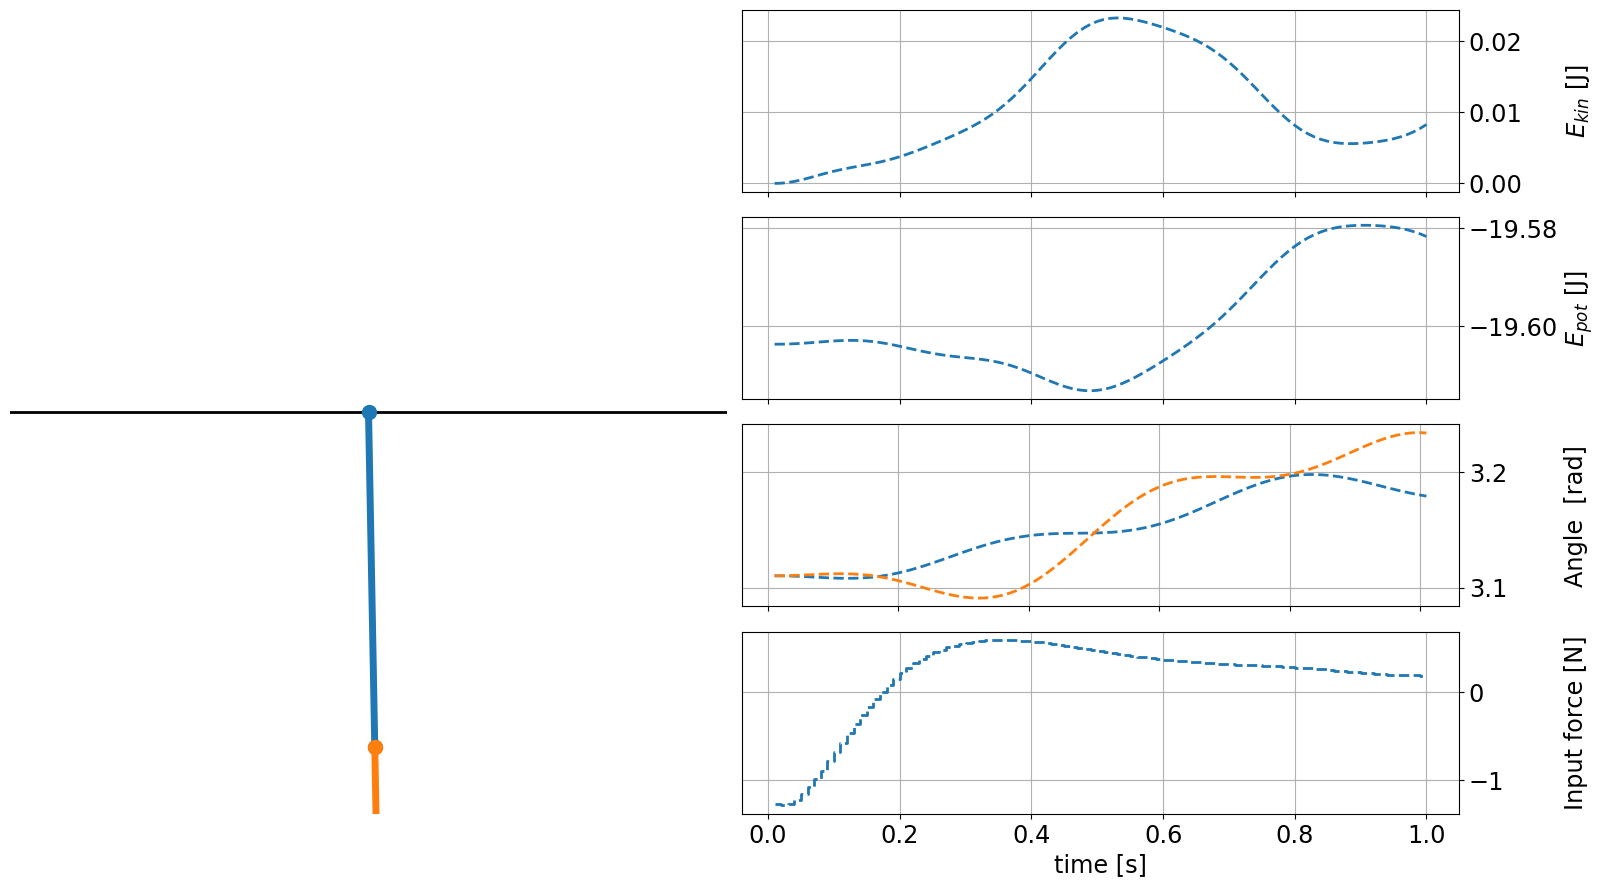

In [39]:
line1, line2 = pendulum_bars(x0)
bar1[0].set_data(line1[0],line1[1])
bar2[0].set_data(line2[0],line2[1])
mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()

fig

In [29]:
mpc_graphics.plot_predictions()

In [30]:
%%capture
# Quickly reset the history of the MPC data object.
mpc.reset_history()

n_steps = 100
for k in range(n_steps):
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)

In [31]:
from matplotlib.animation import FuncAnimation, FFMpegWriter, ImageMagickWriter

# The function describing the gif:
x_arr = mpc.data['_x']
def update(t_ind):
    line1, line2 = pendulum_bars(x_arr[t_ind])
    bar1[0].set_data(line1[0],line1[1])
    bar2[0].set_data(line2[0],line2[1])
    mpc_graphics.plot_results(t_ind)
    mpc_graphics.plot_predictions(t_ind)
    mpc_graphics.reset_axes()




In [32]:
anim = FuncAnimation(fig, update, frames=n_steps, repeat=False)


In [33]:
gif_writer = ImageMagickWriter(fps=60)


In [ ]:
anim.save('anim_dip.gif', writer=gif_writer)

ExecutableNotFoundError: [Errno 2] No such file or directory: 'convert'